In [24]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

# Import packages.
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt

from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi, choi_composition
from opentn.optimization import small2zero, gds, frobenius_norm, model_Ys, compute_loss


d, N = 2, 4
dim = d**N
gamma = 1e-2
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

tol = 1e-12

with open(f'Y1_scs_warm_gds_eps_{tol}.npy', 'rb') as f:
    Y1_cvxpy = np.load(f)
with open(f'Y2_scs_warm_gds_eps_{tol}.npy', 'rb') as f:
    Y2_cvxpy = np.load(f)
with open(f'Y3_scs_warm_gds_eps_{tol}.npy', 'rb') as f:
    Y3_cvxpy = np.load(f)

rhs = np.asarray(super2choi(superop=exp_Lvec, dim=dim))
C2 = choi_composition(C1=small2zero(Y2_cvxpy, tol=tol), C2=small2zero(Y3_cvxpy, tol=tol), dim=dim) 
print(frobenius_norm(choi_composition(small2zero(Y1_cvxpy, tol=tol), C2), small2zero(rhs, tol=tol))) 

# factorize the three layers
X1_cvx = factorize_psd(psd=Y1_cvxpy, tol=tol)
X2_cvx = factorize_psd(psd=Y2_cvxpy, tol=tol)
X3_cvx = factorize_psd(psd=Y3_cvxpy, tol=tol)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
9.476570560628824e-08


9.476504943900039e-08
9.472144514988914e-08


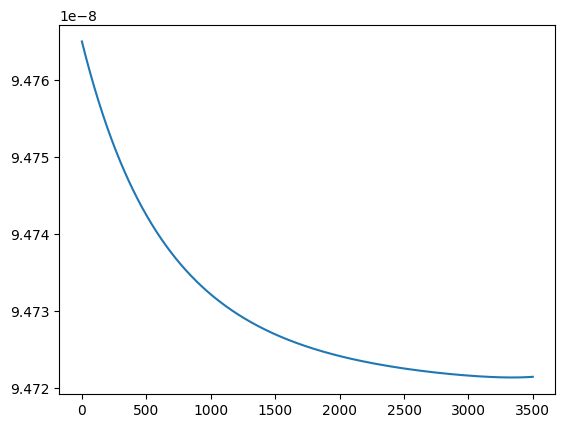

In [2]:
cost_second_opt, grads_second_opt, xi_second_opt = gds(fn=compute_loss, x0=[X1_cvx, X2_cvx, X3_cvx], iter=int(3.5e3), loss_fn=frobenius_norm, model=model_Ys, rate=1e-9, exact = exp_Lvec, show_cost=False)
print(cost_second_opt[0])
print(cost_second_opt[-1])
plt.plot(cost_second_opt)

In [3]:
X1_gds, X2_gds, X3_gds = xi_second_opt[-1]
Y1_gds = X1_gds@X1_gds.conj().T
Y2_gds = X2_gds@X2_gds.conj().T
Y3_gds = X3_gds@X3_gds.conj().T

max_idx = 16

print('CVXPY: \n ')

for op in [Y1_cvxpy, Y2_cvxpy, Y3_cvxpy]:
    print(np.linalg.matrix_rank(op, tol=tol))
    print(np.sort(np.linalg.svd(op, compute_uv=False))[::-1][:max_idx])
    print('----')

print('\nGDS: \n')

for op in [Y1_gds, Y2_gds, Y3_gds]:
    print(np.linalg.matrix_rank(op, tol=tol))
    print(np.sort(np.linalg.svd(op, compute_uv=False))[::-1][:max_idx])
    print('----')

CVXPY: 
 
14
[1.59601248e+01 1.99251772e-02 1.99251750e-02 2.48854409e-05
 5.53046517e-08 4.73911389e-08 4.47700891e-08 4.04551273e-08
 3.85097222e-08 1.87524061e-08 1.35363867e-08 8.17210044e-09
 2.73744317e-12 1.04393719e-12 2.61322204e-13 1.91729697e-13]
----
7
[1.59601992e+01 3.98007427e-02 1.18323156e-10 3.68785161e-11
 9.27037444e-12 6.70717031e-12 3.03205543e-12 8.96682266e-13
 3.18805700e-13 6.87273974e-15 4.87495312e-15 4.28494634e-15
 4.13782880e-15 3.98539272e-15 3.68113501e-15 3.24608906e-15]
----
12
[1.59601248e+01 1.99251810e-02 1.99251788e-02 2.48753728e-05
 2.55544033e-10 7.48022052e-11 6.07035791e-11 5.99426383e-11
 2.53479161e-11 5.87060798e-12 2.36016500e-12 1.46792739e-12
 3.95953541e-13 8.44573067e-14 8.03467510e-14 7.78232283e-14]
----

GDS: 

14
[1.59601248e+01 1.99251769e-02 1.99251750e-02 2.48854409e-05
 5.53046515e-08 4.73911377e-08 4.47700888e-08 4.04551271e-08
 3.85097223e-08 1.87524030e-08 1.35363849e-08 8.17210003e-09
 2.73742452e-12 1.04398012e-12 9.08389

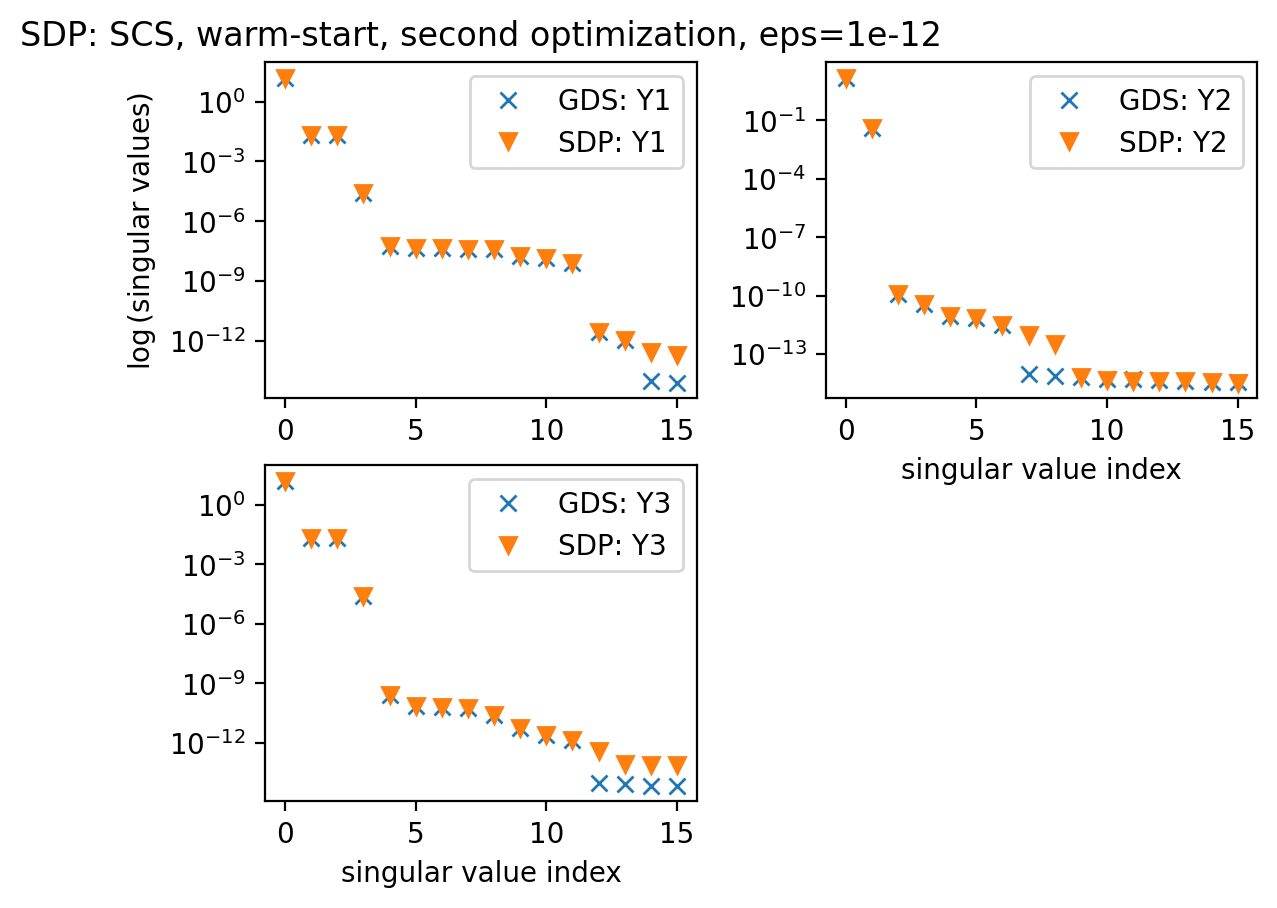

In [4]:
fig = plt.figure(dpi=200)

plt.subplots_adjust(wspace=0.3)

plt.subplot(2,2,1)
plt.title(f'SDP: SCS, warm-start, second optimization, eps={tol}')
plt.ylabel(r'$\log$(singular values)')
plt.semilogy(np.linalg.svd(Y1_gds, compute_uv=False)[:max_idx], 'x', label='GDS: Y1')
plt.semilogy(np.linalg.svd(Y1_cvxpy, compute_uv=False)[:max_idx], 'v', label='SDP: Y1')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel(r'singular value index')
plt.semilogy(np.linalg.svd(Y2_gds, compute_uv=False)[:max_idx], 'x', label='GDS: Y2')
plt.semilogy(np.linalg.svd(Y2_cvxpy, compute_uv=False)[:max_idx], 'v', label='SDP: Y2')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel(r'singular value index')
plt.semilogy(np.linalg.svd(Y3_gds, compute_uv=False)[:max_idx], 'x', label='GDS: Y3')
plt.semilogy(np.linalg.svd(Y3_cvxpy, compute_uv=False)[:max_idx], 'v', label='SDP: Y3')
plt.legend()

In [5]:
# show here a plot with the comparison from initial gds -> cvx -> gds
X1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=tol)
X2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=tol)

from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss
cost_first_opt, grads_first_opt, xi_first_opt = gds(fn=compute_loss, x0=[X1, X2, X1], iter=int(2e3), loss_fn=frobenius_norm, model=model_Ys, rate=1.5e-9, exact = exp_Lvec, show_cost=False)
print(cost_first_opt[0])
print(cost_first_opt[-1])

2.6383007149418305e-07
1.4977787039695335e-07


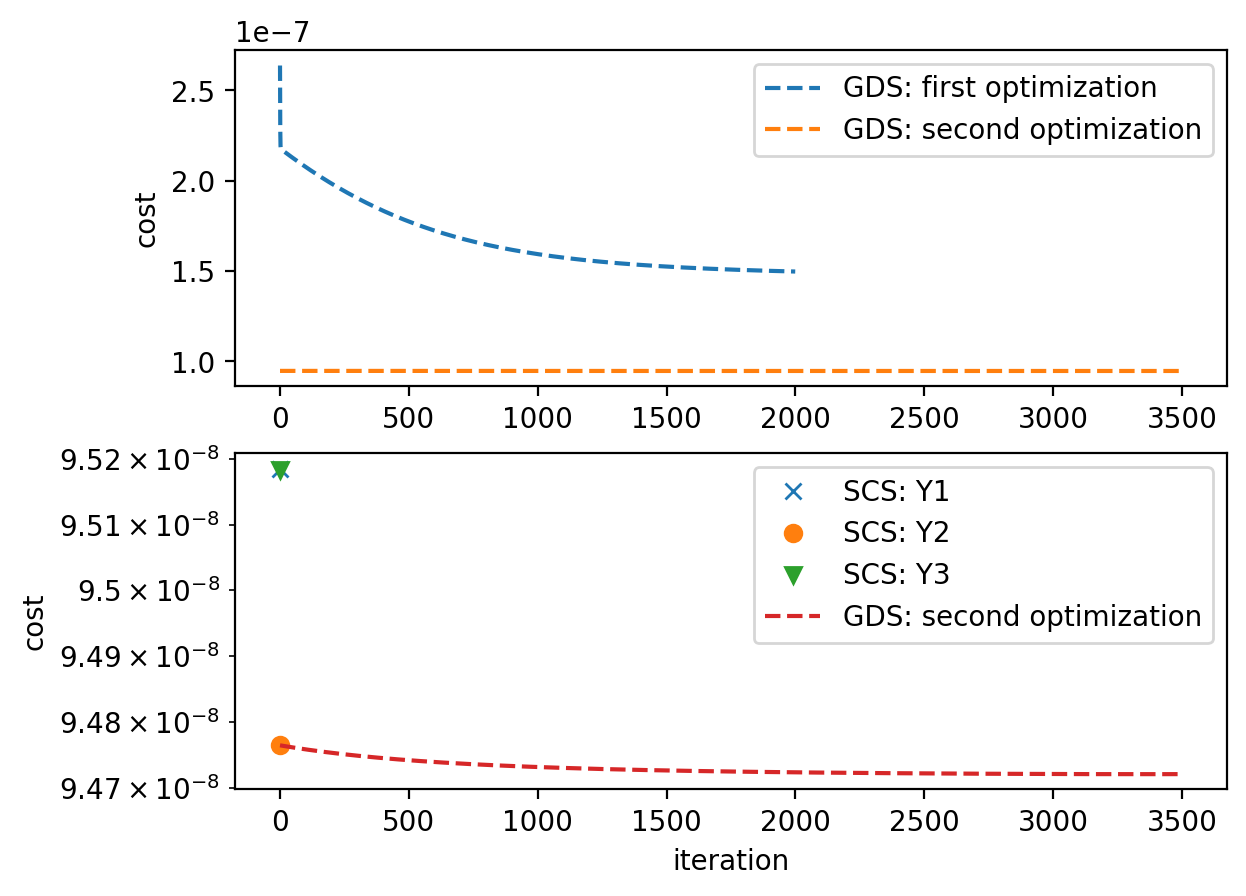

In [6]:
cost_cvx_y1 = 9.518505958793648e-08
cost_cvx_y2 = 9.476497516415284e-08
cost_cvx_y3 = 9.518374307487138e-08

fig = plt.figure(dpi=200)


plt.subplot(2,1,1)
plt.ylabel('cost')
plt.plot(cost_first_opt, '--', label='GDS: first optimization')
plt.plot(cost_second_opt, '--', label='GDS: second optimization')
plt.legend()

plt.subplot(2,1,2)
plt.ylabel('cost')
plt.xlabel('iteration')
plt.plot(cost_cvx_y1, 'x', label='SCS: Y1')
plt.plot(cost_cvx_y2, 'o', label='SCS: Y2')
plt.plot(cost_cvx_y3, 'v', label='SCS: Y3')
plt.semilogy(cost_second_opt, '--', label='GDS: second optimization')
plt.legend()



In [7]:
X1_gds_1opt, X2_gds_1opt, X3_gds_1opt = xi_first_opt[-1]
Y1_gds_1opt = X1_gds_1opt@X1_gds_1opt.conj().T
Y2_gds_1opt = X2_gds_1opt@X2_gds_1opt.conj().T
Y3_gds_1opt = X3_gds_1opt@X3_gds_1opt.conj().T

C2_test = choi_composition(C1=small2zero(Y2_cvxpy, tol=tol), C2=small2zero(Y3_cvxpy, tol=tol), dim=dim) 
print(frobenius_norm(choi_composition(small2zero(Y1_gds_1opt, tol=tol), C2_test), small2zero(rhs, tol=tol))) 

1.4937468743748188e-07


In [8]:
# how close to each other are the matrices Y1, Y3
np.linalg.norm(Y1_gds_1opt - Y3_gds_1opt), np.linalg.norm(Y1_gds - Y3_gds), np.linalg.norm(Y1_gds_1opt - Y2_gds_1opt), np.linalg.norm(Y1_gds - Y2_gds)

(2.3221849630931938e-07,
 2.59744850038663e-07,
 0.0758584244536845,
 0.07585841555950701)

In [ ]:
cost_cvx_y2/cost_first_opt[0]

In [26]:
# Testing if the channels here are also not close to the identity
from opentn.transformations import partial_trace

I = np.eye(dim)
Y1_original = X1@X1.conj().T
Y2_original = X2@X2.conj().T

norm_differences = []

for op in [exp_Lvec, exp_Lvec_odd, exp_Lvec_even]:
    print(np.allclose(I, partial_trace(op=super2choi(op), dims=[dim]*2, idx=0)))
    norm = np.linalg.norm(I - partial_trace(op=super2choi(op), dims=[dim]*2, idx=0))
    print(norm)
    norm_differences.append(norm)

print('---')

for op in [Y1_original, Y2_original, Y1_gds, Y2_gds, Y3_gds]:
    print(np.allclose(I, partial_trace(op=op, dims=[dim]*2, idx=0), atol=1e-8))
    norm = np.linalg.norm(I - partial_trace(op=op, dims=[dim]*2, idx=0))
    print(norm)
    norm_differences.append(norm)

True
5.874748045952207e-16
True
2.482534153247273e-16
True
0.0
---
True
3.014995457568918e-15
True
1.7754189282556822e-15
False
9.285595797063137e-08
True
2.1421326750280227e-08
False
4.417402278413769e-08


In [19]:
for op in [Y1_original, Y2_original, Y1_gds, Y2_gds, Y3_gds]:
    reduced = partial_trace(op=op, dims=[dim]*2, idx=0)
    print(np.diag(reduced))
    print('nonzero elements:', np.count_nonzero(reduced[~np.eye(reduced.shape[0],dtype=bool)]))
    print('-----')

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
nonzero elements: 58
-----
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
nonzero elements: 14
-----
[1.         1.00000001 1.00000002 1.00000002 1.00000002 1.00000002
 1.00000002 1.00000001 1.00000001 1.00000002 1.00000002 1.00000002
 1.00000002 1.00000002 1.00000001 1.        ]
nonzero elements: 240
-----
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
nonzero elements: 240
-----
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
nonzero elements: 240
-----


In [27]:
# lets see what about the matrices optimized with cvxpy
for op in [Y1_cvxpy, Y2_cvxpy, Y3_cvxpy]:
    print(np.allclose(I, partial_trace(op=op, dims=[dim]*2, idx=0), atol=1e-8))
    norm = np.linalg.norm(I - partial_trace(op=op, dims=[dim]*2, idx=0))
    print(norm)
    norm_differences.append(norm)

False
9.300906300433693e-08
True
2.1330963064302935e-08
False
4.4102198131187103e-08


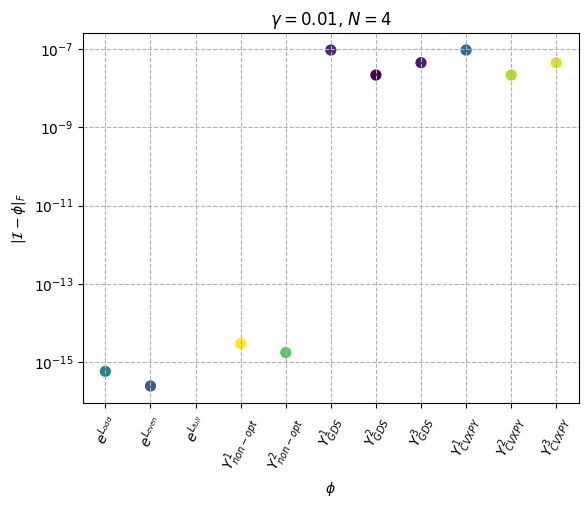

In [31]:
# lets do a plot with the norm difference between I and the op
ax = plt.gca()
labels = [r"$e^{L_{odd}}$", r"$e^{L_{even}}$", r"$e^{L_{full}}$", r"$Y^1_{non-opt}$", r"$Y^2_{non-opt}$", r"$Y^1_{GDS}$", r"$Y^2_{GDS}$", r"$Y^3_{GDS}$",r"$Y^1_{CVXPY}$", r"$Y^2_{CVXPY}$", r"$Y^3_{CVXPY}$"]
ax.xaxis.set_ticks(np.arange(len(labels)))
ax.xaxis.set_ticklabels(labels, rotation=65)

colors = np.random.uniform(15, 80, len(norm_differences))
ax.scatter(np.arange(len(norm_differences)), norm_differences, c=colors, s=50)
ax.set_yscale('log')

plt.title(f'$\gamma = {gamma}$, $N = {N}$')
plt.xlabel(r"$\phi$")
plt.ylabel(r"$| \mathcal{I} - \phi |_{F}$")
plt.grid(ls='--')
plt.show()

(0.9999999999999991+0j)
True
(0.9999999999999993+0j)
True
(0.9999999999999993+0j)
True
---
(1+0j)
True
(0.9999999999999989+0j)
True
(0.9999999994386175+0j)
True
(0.9999999936942081+0j)
True
(1.0000000081880214+0j)
True
(0.9999999994159681+0j)
True
(0.9999999937551474+0j)
True
(1.0000000081703209+0j)
True


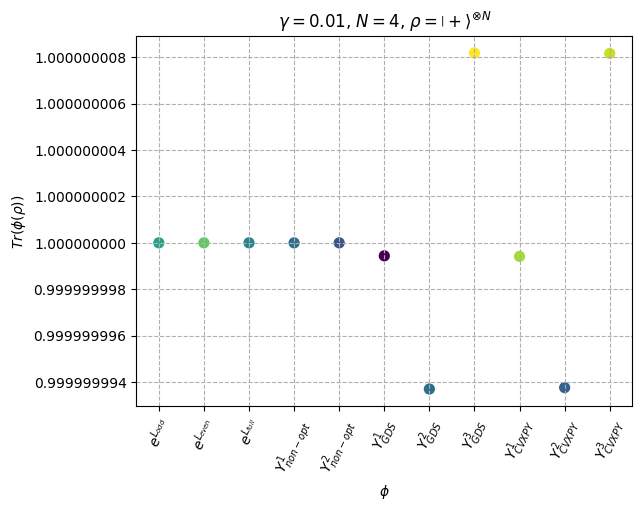

In [36]:
from opentn.states.qubits import plus
from opentn.transformations import ket2dm, vectorize, unvectorize, choi2super
init_state = plus
for i in range(N-1):
    init_state = np.kron(init_state,plus)
init_density = ket2dm(init_state)
init_density_vec = vectorize(init_density)

final_traces = []

# lets apply the operators here and see if the trace is conserved.abs
init_trace = np.trace(init_density)
assert np.allclose(init_trace, 1)

for op in [exp_Lvec, exp_Lvec_odd, exp_Lvec_even]:
    final_density_vec = op@init_density_vec
    final_density = unvectorize(final_density_vec)
    final_trace = np.trace(final_density)
    final_traces.append(final_trace)
    print(final_trace)
    print(np.allclose(final_trace, init_trace))

print('---')

for op in [Y1_original, Y2_original, Y1_gds, Y2_gds, Y3_gds, Y1_cvxpy, Y2_cvxpy, Y3_cvxpy]:
    op = choi2super(op)
    final_density_vec = op@init_density_vec
    final_density = unvectorize(final_density_vec)
    final_trace = np.trace(final_density)
    final_traces.append(final_trace)
    print(final_trace)
    print(np.allclose(final_trace, init_trace))

ax = plt.gca()
labels = [r"$e^{L_{odd}}$", r"$e^{L_{even}}$", r"$e^{L_{full}}$", r"$Y^1_{non-opt}$", r"$Y^2_{non-opt}$", r"$Y^1_{GDS}$", r"$Y^2_{GDS}$", r"$Y^3_{GDS}$",r"$Y^1_{CVXPY}$", r"$Y^2_{CVXPY}$", r"$Y^3_{CVXPY}$"]
ax.xaxis.set_ticks(np.arange(len(labels)))
ax.xaxis.set_ticklabels(labels, rotation=65)
ax.get_yaxis().get_major_formatter().set_useOffset(False)


colors = np.random.uniform(15, 80, len(final_traces))
ax.scatter(np.arange(len(final_traces)), final_traces, c=colors, s=50)
plt.title(f'$\gamma = {gamma}$, $N = {N}$, ' + r'$\rho = \left| + \right\rangle^{\otimes N}$')
plt.xlabel(r"$\phi$")
plt.ylabel(r"$ Tr(\phi(\rho)) $")
plt.grid(ls='--')
plt.show()